In [6]:
%matplotlib inline
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt

In [3]:
today = ql.Date(17, ql.October, 2016)
ql.Settings.instance().evaluationDate = today

For illustration purposes, I’ll create a bond curve using the same data and algorithm shown in one
of the QuantLib C++ examples; namely, I’ll give to the curve the functional form defined by the
Nelson-Siegel model and I’ll fit it to a number of bond. Here are the maturities in years and the
coupons of the bonds I’ll use:

In [4]:
data = [
    (2, 0.02), (4, 0.0225), (6, 0.025), (8, 0.0275),
    (10, 0.03), (12, 0.0325), (14, 0.035), (16, 0.0375),
    (18, 0.04), (20, 0.0425), (22, 0.045), (24, 0.0475),
    (26, 0.05), (28, 0.0525), (30, 0.055)
]

In [5]:
# Assume price = 100 for all

calendar = ql.TARGET()
settlement = calendar.advance(today, 3, ql.Days)
quotes = []
helpers = []
for length, coupon in data:
    maturity = calendar.advance(
        settlement,
        length,
        ql.Years
    )
    schedule = ql.Schedule(
        settlement,
        maturity,
        ql.Period(ql.Annual),
        calendar,
        ql.ModifiedFollowing,
        ql.ModifiedFollowing,
        ql.DateGeneration.Backward,
        False
    )
    quote = ql.SimpleQuote(100.0)
    quotes.append(quote)
    helpers.append(
        ql.FixedRateBondHelper(
            ql.QuoteHandle(quote), 3, 100.0,
            schedule, [coupon], ql.SimpleDayCounter(),
            ql.ModifiedFollowing
        )
    )
curve = ql.FittedBondDiscountCurve(
    0,
    calendar,
    helpers,
    ql.SimpleDayCounter(),
    ql.NelsonSiegelFitting()
)

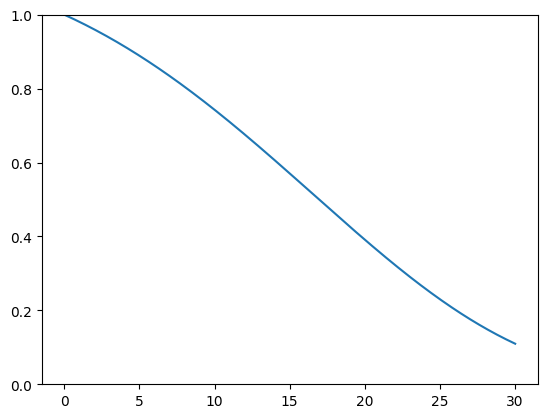

In [9]:
sample_times = np.linspace(0.0, 30.0, 301)
sample_discounts = [curve.discount(t) for t in sample_times]
plt.plot(sample_times, sample_discounts)
plt.ylim(0.0, 1.0)
plt.show()

Now we price a bond by discounting its coupons on the curve:

In [11]:
schedule = ql.Schedule(
    today,
    calendar.advance(today, 15, ql.Years),
    ql.Period(ql.Semiannual),
    calendar,
    ql.ModifiedFollowing,
    ql.ModifiedFollowing,
    ql.DateGeneration.Backward,
    False
)
bond = ql.FixedRateBond(3, 100.0, schedule, [0.04], ql.Actual360())
bond.setPricingEngine(
    ql.DiscountingBondEngine(ql.YieldTermStructureHandle(curve))
)
print(bond.cleanPrice())

105.77449622178025


Now, let’s add an observer that checks whether the bond is out of date, and if so recalculates the
bond and outputs its new price. In Python, I can do this by defining a function to be triggered by the
notifications, by passing it to the observer I’m creating, and (this last step is as in C++) by registering
the observer with the bond.

in this case, the bond whose price it wants to monitor. A change in any of the market
quotes will cause the quote to notify the helper, which in turn will notify the curve, and so on to the
pricing engine, the bond and finally our observer.

In [12]:
prices = []
def print_price():
    p = bond.cleanPrice()
    prices.append(p)
    print(p)
o = ql.Observer(print_price)
o.registerWith(bond)

In [18]:
quotes[2].setValue(101.0)

105.77449622178025
105.86560413454633


WTH?  
The function was called twice, which surprised me too.  
It turns out that, due to a glitch of multiple inheritance, the curve sends two notifications
to the instrument. After the first, the instrument recalculates but the curve doesn’t (which explains
why the price doesn’t change); after the second, the curve updates and the price changes. This should
be fixed in a future release, but again it doesn’t change the point of the notebook.
Let’s set the quote back to its original value.

In [19]:
quotes[2].setValue(100.0)

105.86560413454633
105.77449632602422


In [23]:
prices = []
for q in quotes:
    q.setValue(101.0)

105.77449628000558
105.28388395466223
105.28388395466223
105.21862872105208
105.21862872105208
105.31959066297566
105.31959066297566
105.48786664556528
105.48786664556528
105.68032068196598
105.68032068196598
105.8758038874638
105.8758038874638
106.06201697094023
106.06201697094023
106.23044665119893
106.23044665119893
106.37409247796555
106.37409247796555
106.48708851230232
106.48708851230232
106.56505215610473
106.56505215610473
106.60570731612138
106.60570731612138
106.60980179033257
106.60980179033257
106.58011155376235
106.58011155376235
106.52070692307088


Each of the updates sent a notification and thus triggered a recalculation. We can use
the list of prices we collected (slicing it to skip duplicate values) to visualize how the price changed.

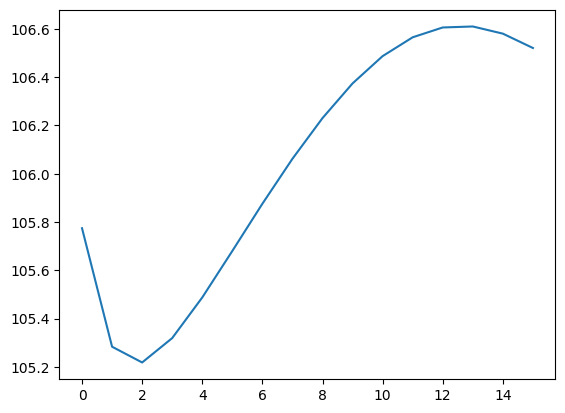

In [25]:
unique_prices = prices[::2]+prices[-1::]
ax = plt.plot(unique_prices, '-')
plt.show()

The first price is the original one, and the last price is the final one; but all those in between are
calculated based on an incomplete set of changes in which some quotes were updated and some
others weren’t. Those are all incorrect, and (since they went both above and below the range of the
real prices) outright dangerous in case there were any triggers on price levels that could have fired.
Clearly, this is not the kind of behavior we want our code to have.

## Workarounds

- Freeze bond
- Pull, don't push

In [26]:
# let's remove the observer
del o
# instead create one that raises a flag when notified

In [27]:
flag = {}
flag ['status'] = 'down'
def set_flag():
    flag['status'] = 'up'
o = ql.Observer(set_flag)
o.registerWith(bond)

In [29]:
print(flag)

{'status': 'down'}


In [30]:
for q in quotes:
    q.setValue(100.0)

In [31]:
print(flag)

{'status': 'up'}


At this point, we can ask the bond for its final price.

In [32]:
bond.cleanPrice()

105.77449629793355

We can even the instrument do that: let’s remove the second observer too, and just ask
the instrument for its price after the changes. The instrument keeps track of whether it needs
recalculation, so it doesn’t need us to keep track of it.

In [33]:
del o

In [34]:
for q in quotes:
    q.setValue(101.0)

In [35]:
bond.cleanPrice()

106.52070671003756